In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from datetime import datetime
from matplotlib import dates as md
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

### About the Data
We are using the data which consists Online advertisement clicking rates, where the metrics are cost-per-click (CPC). There are 2 files, one of the files is normal, without anomalies and another with anomalies.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_ad_exchange_cpc_withoutanomaly_url_suffix = "realAdExchange/exchange-2_cpc_results.csv"
df_ad_exchange_cpc_withoutanomaly_url = master_url_root + df_ad_exchange_cpc_withoutanomaly_url_suffix
df_ad_exchange_cpc_withoutanomaly = pd.read_csv(df_ad_exchange_cpc_withoutanomaly_url)

df_ad_exchange_cpc_withanomaly_url_suffix = "realAdExchange/exchange-3_cpc_results.csv"
df_ad_exchange_cpc_withanomaly_url = master_url_root + df_ad_exchange_cpc_withanomaly_url_suffix
df_ad_exchange_cpc_withanomaly = pd.read_csv(df_ad_exchange_cpc_withanomaly_url)


#### Statistical parameters for the Dataset without Anomalies

In [3]:
df_ad_exchange_cpc_withoutanomaly.describe()

,value
count,1624.000000
mean,0.101823
std,0.033729
min,0.026843
25%,0.076633
50%,0.100833
75%,0.123618
max,0.226598


#### Statistical parameters for the Dataset with Anomalies

In [4]:
df_ad_exchange_cpc_withanomaly.describe()

,value
count,1538.000000
mean,0.137259
std,0.075671
min,0.038899
25%,0.097923
50%,0.118184
75%,0.153230
max,1.034000


In [5]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

### Data Without Anomalies Plot

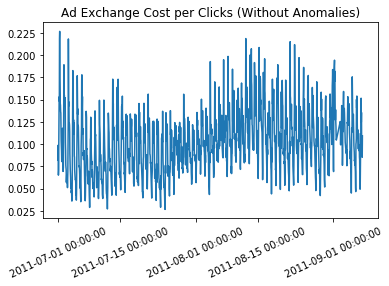

In [8]:
plt.title('Ad Exchange Cost per Clicks (Without Anomalies)')
plot_dates_values(df_ad_exchange_cpc_withoutanomaly)

### Data with anomalies Plot

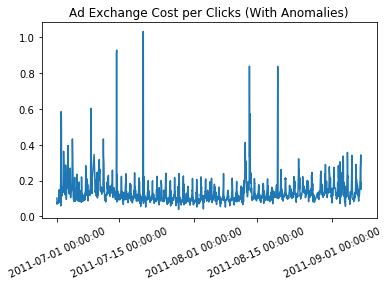

In [7]:
plt.title('Ad Exchange Cost per Clicks (With Anomalies)')
plot_dates_values(df_ad_exchange_cpc_withanomaly)

## Data Preprocessing

In [9]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


In [19]:
def create_Xt_Yt(X, Y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = Y[0:p]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    
    X_test = X[p:]
    Y_test = Y[p:]
    
    return X_train, X_test, Y_train, Y_test

#### Normalizing the datasets

In [20]:
train_values = df_ad_exchange_cpc_withoutanomaly.value.to_list()
test_values = df_ad_exchange_cpc_withanomaly.value.to_list()
df_mean = mean(train_values)
df_std = std(train_values)
train_values = (train_values-df_mean)/df_std
test_values = (test_values-df_mean)/df_std

#### Defining a function to find the anomalies



In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D
from time import time
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.losses import MeanSquaredError

In [264]:
def Anomaly_pred(df_without_anomaly,df_with_anomaly,STEP,WINDOW,FORECAST):
    X, Y = [], []
    train_values = df_without_anomaly.value.to_list()
    test_values = df_with_anomaly.value.to_list()
    for i in range(0,len(train_values)-WINDOW-FORECAST,STEP):
        try:
            x_i = train_values[i:i+WINDOW]
            y_i = train_values[i+WINDOW:i+WINDOW+FORECAST]
            
        except Exception as e:
            print(e)
            break
            
        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    x_train, x_test, y_train, y_test = create_Xt_Yt(X, Y)
    input_shape = x_train[0].shape
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dense(FORECAST))
#     model.add(Activation('softmax'))

    optimizer = Adam()
    print(model.summary())
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer='sgd',
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(x_train,y_train,
                  batch_size=64,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_test, y_test))
    ### to see the predictions on without anomalies data
    predictions_withoutanomaly = model.predict(X)

    
    X_anomaly, Y_anomaly = [], []
    for i in range(0,len(test_values)-WINDOW-FORECAST,STEP):
        try:
            x_i = test_values[i:i+WINDOW]
            y_i = test_values[i+WINDOW:i+WINDOW+FORECAST]
            
        except Exception as e:
            print(e)
            break
            
        X_anomaly.append(x_i)
        Y_anomaly.append(y_i)

        
    predictions_anomaly = model.predict(X_anomaly)
    
    
    X_anomaly, Y_anomaly = np.array(X_anomaly), np.array(Y_anomaly)
    err = []
    
    
    ### mse error type
    mse_err = []
    mse_err = np.mean(np.square(predictions_withoutanomaly - Y), axis=1)
    mse_threshold = max(mse_err)
    mse_err_anomaly = np.mean(np.square(predictions_anomaly - Y_anomaly), axis=1)
    mse_anomalies = (mse_err_anomaly > mse_threshold).tolist()
    
    ### mae error type
    mae_err = []
    mae_err = np.mean(np.abs(predictions_withoutanomaly - Y), axis=1)
    mae_threshold = max(mae_err)
    mae_err_anomaly = np.mean(np.abs(predictions_anomaly - Y_anomaly), axis=1)
    mae_anomalies = (mae_err_anomaly > mae_threshold).tolist()
    
    ### cosine similarity 
    cos_sim = []
    sim = cosine_similarity(predictions_withoutanomaly,Y)
    for i in range(len(Y)):
        cos_sim.append(sim[i,i])
    cos_min_threshold = min(cos_sim)
    err_anomaly_sim = cosine_similarity(predictions_anomaly,Y_anomaly)
    cos_sim_anomaly  =[]
    for i in range(len(Y_anomaly)):
        cos_sim_anomaly.append(err_anomaly_sim[i,i])
    cos_anomalies = (cos_sim_anomaly < cos_min_threshold).tolist()
    
    
    
    ### for mse anomalies
    mse_indices = []
    for data_idx in range(WINDOW+FORECAST - 1, len(Y_anomaly)-WINDOW - FORECAST + 1):
        time_series = range(data_idx - FORECAST + 1, data_idx)
        if all([mse_anomalies[j] for j in time_series]):
            temp = [data_idx-1,data_idx,data_idx+1] # if data_idx > 0 else [data_idx,data_idx+1]
    # if data_idx == len(test_value) :
    #   temp.pop()
            mse_indices.append(temp)
#     for data_idx in range(FORECAST - 1, len(mse_anomaly) - FORECAST + 1):
#         time_series = range(data_idx - FORECAST + 1, data_idx)
#         if all([anomalies[j] for j in time_series]):
#             anomalous_data_indices.append(data_idx+WINDOW)
    
    ### mae anomalies
    mae_indices= []
    for data_idx in range(WINDOW+FORECAST - 1, len(Y_anomaly)-WINDOW - FORECAST + 1):
        time_series = range(data_idx - FORECAST + 1, data_idx)
        if all([mae_anomalies[j] for j in time_series]):
            temp = [data_idx-1,data_idx,data_idx+1] # if data_idx > 0 else [data_idx,data_idx+1]
    # if data_idx == len(test_value) :
    #   temp.pop()
            mae_indices.append(temp)
    
    
    ### cosine similarity
    cos_indices = []
    for data_idx in range(WINDOW+FORECAST - 1, len(Y_anomaly)-WINDOW - FORECAST + 1):
        time_series = range(data_idx - FORECAST + 1, data_idx)
        if all([cos_anomalies[j] for j in time_series]):
            temp = [data_idx-1,data_idx,data_idx+1] # if data_idx > 0 else [data_idx,data_idx+1]
    # if data_idx == len(test_value) :
    #   temp.pop()
            cos_indices.append(temp)
    
    
    return model,history,mse_indices,mae_indices,cos_indices,mse_err,mse_err_anomaly,mae_err,mae_err_anomaly,cos_sim,cos_sim_anomaly
    


In [193]:
def anomaly_plot(indices,window_size,measure):
    df_highlighted_anamoly = []
    for i in indices:
        df_subset = df_ad_exchange_cpc_withanomaly.iloc[i, :]
        df_highlighted_anamoly.append(df_subset)

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    dates = df_ad_exchange_cpc_withanomaly["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = df_ad_exchange_cpc_withanomaly["value"].to_list()
    plt.plot(dates, values, label="test data")#, color="g")

    for anamoly in df_highlighted_anamoly:
        dates = anamoly["timestamp"].to_list()
        dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
        values = anamoly["value"].to_list()
        plt.plot(dates, values, color="r")
    # print(values,len(values))
    plt.legend()
    plt.title('Plotting the data indicating the Anomalies using '+measure+' and Window size = '+ window_size)
    plt.show()

### Error Type = Mean Squared Error

#### With Window Size  = 100

In [328]:
model_100,history_100,mse_indices_100,mae_indices_100,cos_indices_100,mse_err_100,mse_err_anomaly_100,mae_err_100,mae_err_anomaly_100,cos_sim_100,cos_sim_anomaly_100= Anomaly_pred(df_ad_exchange_cpc_withoutanomaly,
                                                                                                                                               df_ad_exchange_cpc_withanomaly,
                                                                                                                                               1,100,5)



Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 128)               12928     
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 5)                 645       
_________________________________________________________________
activation_41 (Activation)   (None, 5)                 0         
Total params: 14,085
Trainable params: 13,829
Non-trainable params: 256
_________________________________________________________________
None
Train on 1367 samples, validate on 152 samples
Epoch 1/50
1367/1367 [==============================] - 0s 25

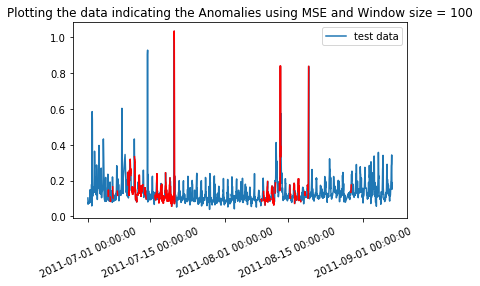

In [296]:
anomaly_plot(mse_indices_100,'100','MSE')

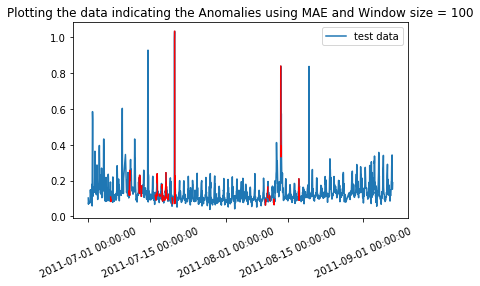

In [297]:
anomaly_plot(mae_indices_100,'100','MAE')

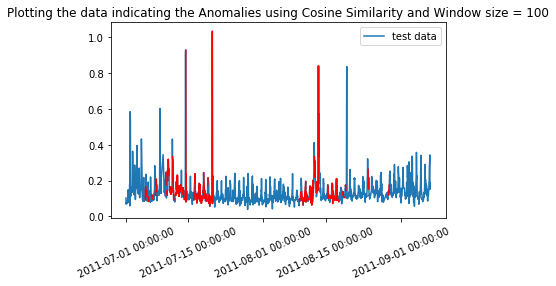

In [298]:
anomaly_plot(cos_indices_100,'100','Cosine Similarity')

### With Window Size = 50

In [329]:
model_50,history_50,mse_indices_50,mae_indices_50,cos_indices_50,mse_err_50,mse_err_anomaly_50,mae_err_50,mae_err_anomaly_50,cos_sim_50,cos_sim_anomaly_50 = Anomaly_pred(df_ad_exchange_cpc_withoutanomaly,df_ad_exchange_cpc_withanomaly,1,50,5)



Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 128)               6528      
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 5)                 645       
_________________________________________________________________
activation_42 (Activation)   (None, 5)                 0         
Total params: 7,685
Trainable params: 7,429
Non-trainable params: 256
_________________________________________________________________
None
Train on 1412 samples, validate on 157 samples
Epoch 1/50
1412/1412 [==============================] - 0s 255u

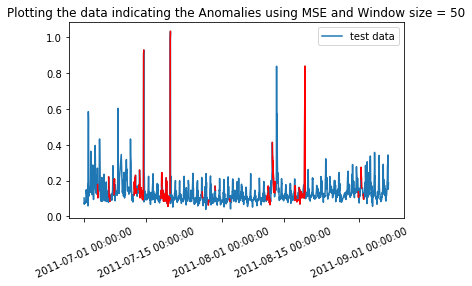

In [318]:
anomaly_plot(mse_indices_50,'50','MSE')

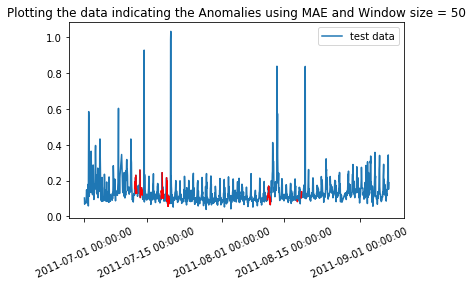

In [319]:
anomaly_plot(mae_indices_50,'50','MAE')

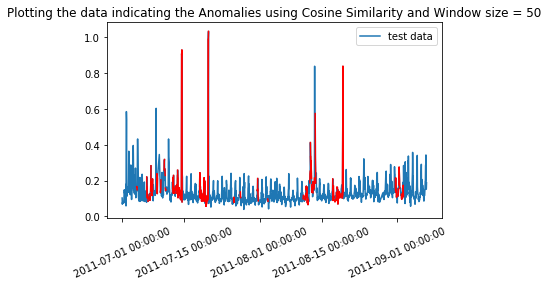

In [320]:
anomaly_plot(cos_indices_50,'50','Cosine Similarity')

### With Window Size = 25

In [330]:
model_25,history_25,mse_indices_25,mae_indices_25,cos_indices_25,mse_err_25,mse_err_anomaly_25,mae_err_25,mae_err_anomaly_25,cos_sim_25,cos_sim_anomaly_25 = Anomaly_pred(df_ad_exchange_cpc_withoutanomaly,df_ad_exchange_cpc_withanomaly,1,25,5)



Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 128)               3328      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 5)                 645       
_________________________________________________________________
activation_43 (Activation)   (None, 5)                 0         
Total params: 4,485
Trainable params: 4,229
Non-trainable params: 256
_________________________________________________________________
None
Train on 1434 samples, validate on 160 samples
Epoch 1/50
1434/1434 [==============================] - 0s 245u

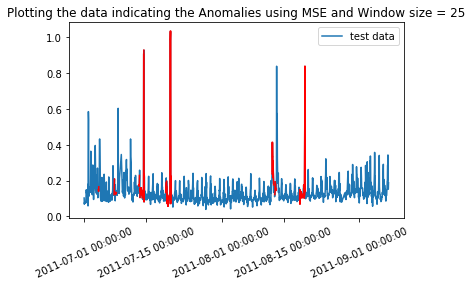

In [304]:
anomaly_plot(mse_indices_25,'25','MSE')

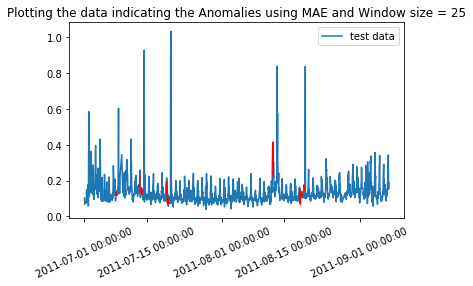

In [305]:
anomaly_plot(mae_indices_25,'25','MAE')

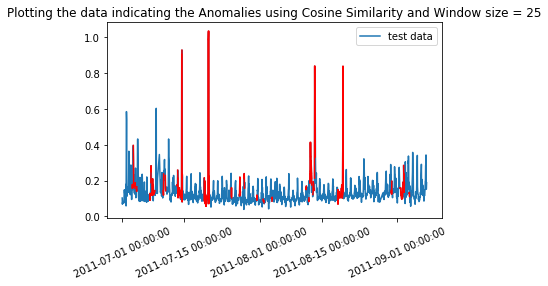

In [306]:
anomaly_plot(cos_indices_25,'25','Cosine Similarity')

In [307]:
print('Number anomalies detected by the Models for different window sizes with MSE as Measure')
len(mse_indices_100),len(mse_indices_50),len(mse_indices_25)

Number anomalies detected by the Models for different window sizes with MSE as Measure


(161, 94, 62)

In [308]:
print('Number anomalies detected by the Models for different window sizes with MAE as Measure')

len(mae_indices_100),len(mae_indices_50),len(mae_indices_25)

Number anomalies detected by the Models for different window sizes with MAE as Measure


(31, 23, 17)

In [309]:
print('Number anomalies detected by the Models for different window sizes with Cosine Similarity as Measure')

len(cos_indices_100),len(cos_indices_50),len(cos_indices_25)

Number anomalies detected by the Models for different window sizes with Cosine Similarity as Measure


(166, 82, 111)

## Observations

In all the plots we can see some non-anomalous points to classified as anomalies, this might be due to the model trained on a similar data without anomalies but not exactly the same data, so the model might predict the values away from real trend at some points and hence their errors might be greater than the threshold, even though they are not anomalies. From the above results indicating number of anomalies detected for each window size given a distance measure type, that the model with 50 and 25 window size has least number of anomalies, while the model with 100 window size are higher.

In all the models we can see that with MSE or Cosine similarity as Measure, most of the anomalies are detected properly even though there are many False Positives (or Negatives this isn't a classification type), while MAE as measure it predicted only some of the anomalies but has lower False Positives compared to the other measures.

We can also see that the model with window size 25 has better anomalies identified compared to the higher window size

Note- in All the Models using different metrics the initial anomalies are not identified that is because those data points are not predicted because of the initial window size.


### Comparing the Performance of each model

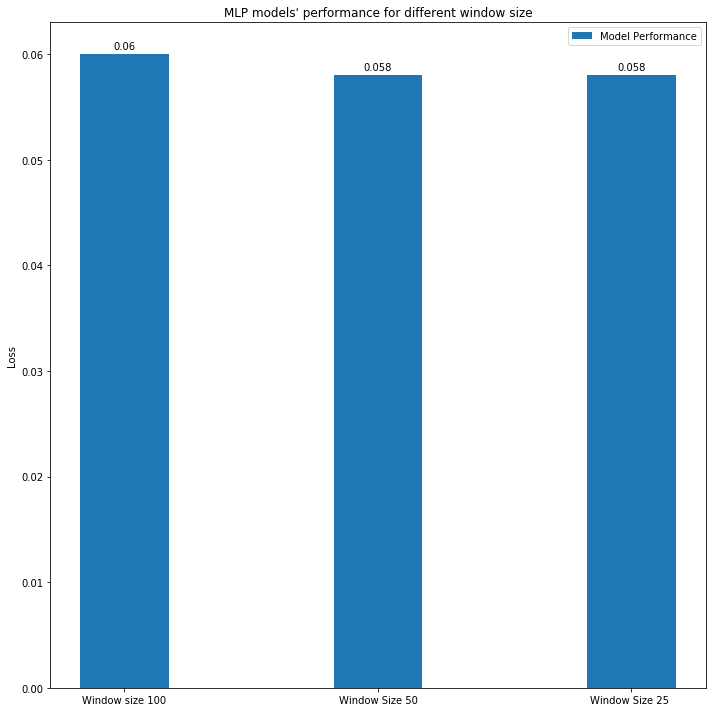

In [177]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Window size 100', 'Window Size 50', 'Window Size 25 ']
model_loss = [round(history_100_mse.history['loss'][-1],3), round(history_50.history['loss'][-1],3), round(history_25.history['loss'][-1],3)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# plt.figure(figsize=[20,20])
fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x , model_loss, width, label='Model Performance')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title("MLP models' performance for different window size")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)


fig.tight_layout()

plt.show()

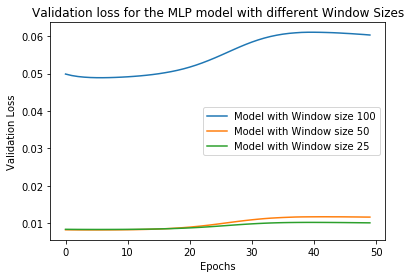

In [331]:
plt.plot(history_100_mse.history['val_loss'])
plt.plot(history_50.history['val_loss'])
plt.plot(history_25.history['val_loss'])
plt.title('Validation loss for the MLP model with different Window Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(['Model with Window size 100', 'Model with Window size 50','Model with Window size 25'], loc='best')


In the above plot we can see that the Model wtrained with window size 100 has higher Validation loss compared to the lower window sizes indicating that the model is over trained on the Data Without Anomalies,hence not able to predict the trends hence with this model more points are classifies as anomalies even though they are not. We can see that the models are trained before the 20th epoch.(but when increasing the epochs(greater than 50) its just fluctuating around those ranges as shown above)